# Preamble

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation

Redshift Distribution approximately follows M-D 2014.
$$
z \sim 10\beta_z(3, 9)
$$

In [3]:
Nobs = 1000

Text(0, 0.5, 'Number')

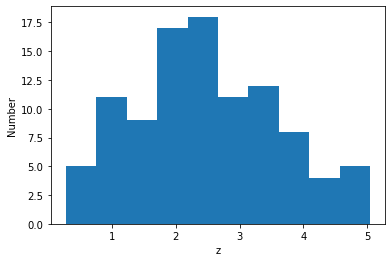

In [4]:
z = np.random.beta(3, 9, Nobs)*10
plt.hist(z)
plt.xlabel('z')
plt.ylabel('Number')

Source frame chirp mass follows galactic neutron star population,

$$
M_c \sim N(1.17 M_{\odot}, 0.1M_{\odot})
$$

Text(0, 0.5, 'Number')

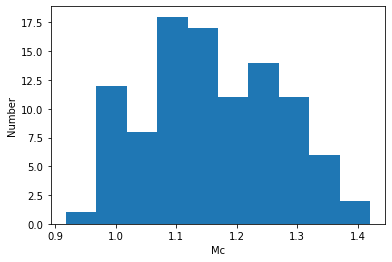

In [5]:
Mc = np.random.normal(1.17, 0.1, Nobs) # in solar mass unit
plt.hist(Mc)
plt.xlabel('Mc')
plt.ylabel('Number')

Detector frame chirp mass,
$$
Mcz = Mc(1+z)
$$

Text(0, 0.5, 'Number')

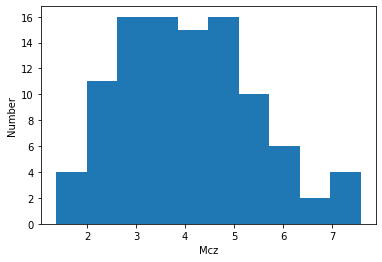

In [6]:
Mcz = Mc*(1+z)
plt.hist(Mcz)
plt.xlabel('Mcz')
plt.ylabel('Number')

Cosmology is assumed to be Planck18. $\sigma_{DL}/DL$ is inversely proportional to snr, reaching 30% of snr at z=10. Also place a lower cut $\sigma_{DL}/DL$ is 0.1 to avoid unphysical scenario of $\sigma_{DL} \rightarrow 0$ at low $z$.

$$
\sigma_{logDL} = \frac{\sigma_{DL}}{DL} = 0.1 + 0.3 \frac{DL}{DL(z=10)}
$$

Text(0, 0.5, 'Number')

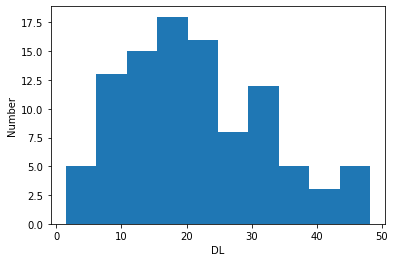

In [7]:
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value
plt.hist(DL)
plt.xlabel('DL')
plt.ylabel('Number')

In [8]:
DL10 = cp.luminosity_distance(10).to(u.Gpc).value
sigma_logDL = 0.1+0.3*(DL/DL10)

$$
zo = z, logdo = logDL+\sigma_{logDL}*randn(Nobs)
$$

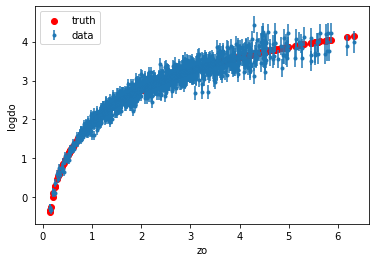

In [9]:
zo = z
logdo = np.log(DL)+sigma_logDL*np.random.randn(Nobs) # in Gpc
plt.errorbar(zo, logdo, yerr=sigma_logDL, fmt='.', label='data')
plt.scatter(zo, np.log(cp.luminosity_distance(zo).to(u.Gpc).value), color='red', label='truth')
plt.xlabel('zo')
plt.ylabel('logdo')
plt.legend()

# Pop Cosmo Estimation

Let's plot the residue.

Text(0, 0.5, 'residue')

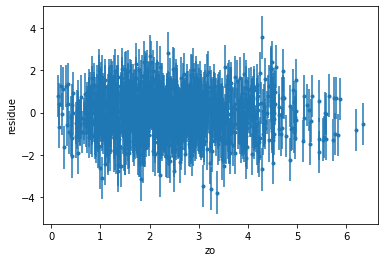

In [10]:
plt.errorbar(zo, (logdo-np.log(cp.luminosity_distance(zo).to(u.Gpc).value))/sigma_logDL, yerr=np.ones(Nobs), fmt='.')
plt.xlabel('zo')
plt.ylabel('residue')

# Toy Model I

Here $\vec{\Omega}_P = \{\mu_P, \sigma_P \}$, and $\vec{\Omega}_C = \{H_0, \Omega_M, w \}$.

Under simplified asuumptions:
1. no covariance between $M_{cz}^{obs}$ and $logD_L^{obs}$,
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ is,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [11]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [12]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \int_{logD_L} N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P).dlogD_L \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) , \right\rangle _{logD_L \sim N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P(z(D_L, H_0, \Omega_M, w)).\\
\frac{dz}{dD_L}\Big |_{z(D_L, H_0, \Omega_M, w)}.\frac{dD_L}{dlogD_L}.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) \right\rangle _{D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

Now $z_{unit} = \frac{z(D_L, H_0, \Omega_M, w)}{10}$, gives $P(z(D_L, H_0, \Omega_M, w)) = P(z_{unit})\frac{dz_{unit}}{dz} = P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{1}{10}$, and $\frac{dD_L}{dlogD_L}=D_L$. Hence,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \left\langle \prod_i \left\langle P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\\
\frac{D_L/10}{\frac{dD_L}{dz}\Big |_{z(D_L, H_0, \Omega_M, w)}}.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}\Big )}(\mu_P, \sigma_P) \right\rangle _{D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples} \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w ~samples}
$$

where,

$$
D_L = dH.(1+z).\int_0^z \frac{dz^{\prime}}{E(z^{\prime})} \Rightarrow \frac{dD_L}{dz} = \frac{D_L}{1+z} + \frac{dH.(1+z)}{E(z)} ~\Big(\text{Here}, ~dH = \frac{c}{H_0}\Big)
$$

In [13]:
Ns = 10**2
logds = np.zeros([Nobs, Ns])

for i in range(Nobs):
    logds[i] = np.random.normal(logdo[i], sigma_logDL[i], Ns).T

In [14]:
wDM = 0

Structure of input data:

Mcz = 

    [[sample1 for event1, sample2 for event1,...,sampleNs for event1],

     [sample1 for event2, sample2 for event2,...,sampleNs for event2],
     
     .
     
     .
     
     .
     
     [sample1 for eventNobs, sample2 for eventNobs,...,sampleNs for eventNobs]]

logds = 
     
     [[sample1 for event1, sample2 for event1,...,sampleNs for event1],

     [sample1 for event2, sample2 for event2,...,sampleNs for event2],
     
     .
     
     .
     
     .
     
     [sample1 for eventNobs, sample2 for eventNobs,...,sampleNs for eventNobs]]

In [15]:
Mczo = np.zeros([Nobs, Ns])

for i in range(Nobs):
    Mczo[i].fill(Mcz[i])

In [19]:
print(Mczo, logds)

[[5.96967553 5.96967553 5.96967553 ... 5.96967553 5.96967553 5.96967553]
 [2.76690282 2.76690282 2.76690282 ... 2.76690282 2.76690282 2.76690282]
 [2.6282919  2.6282919  2.6282919  ... 2.6282919  2.6282919  2.6282919 ]
 ...
 [3.4847984  3.4847984  3.4847984  ... 3.4847984  3.4847984  3.4847984 ]
 [3.65645961 3.65645961 3.65645961 ... 3.65645961 3.65645961 3.65645961]
 [5.11747748 5.11747748 5.11747748 ... 5.11747748 5.11747748 5.11747748]] [[4.46124779 4.39246015 4.41824281 ... 3.93013127 4.10948125 3.90859218]
 [2.09665183 2.26737853 1.99370583 ... 2.20907147 2.11498617 1.93709983]
 [2.00862826 2.29844115 2.03792454 ... 1.88748382 2.03694369 2.01274867]
 ...
 [2.94624485 2.77401508 3.05765196 ... 3.01055709 2.95760962 2.69668154]
 [3.39415154 3.02970518 3.26168358 ... 2.83266316 3.45410749 3.05713023]
 [3.24729479 3.43959905 3.50169856 ... 3.12267211 3.36981862 3.1900048 ]]


In [20]:
def make_model(Mczo, logds, zmax=100, Nz=1024):

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 0.7, 1.7) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.05, 0.15)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc
        
        ds = at.exp(logds)
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z = at_interp(ds, dLinterp, zinterp)
        z_unit = z/10
        
        var = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit))
        ddLdz = ds/(1+z)+dH*(1+z)/Ez(z, Om, w, wDM)
        var1 = ds/(10*ddLdz)
        var2 = 1/(1+z)
        Mc = Mczo/(1 + z)
        var3 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), Mc))
        var4 = at.sum(var*var1*var2*var3, axis=1)
        pm.Potential('pos', at.sum(at.log(var4)))
    return model

In [21]:
tune = 1000
target_accept = 0.99
with make_model(Mczo, logds) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, sigma_P, h, Om, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22387 seconds.


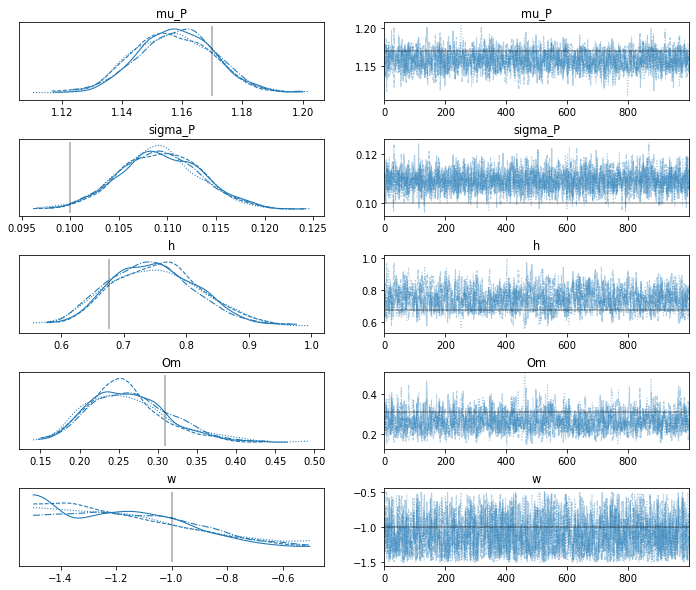

In [22]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'],
                        lines=[('mu_P', {}, 1.17),
                        ('sigma_P', {}, 0.1),
                        ('h', {}, cp.H0/100),
                        ('Om', {}, cp.Om0),
                        ('w', {}, -1)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

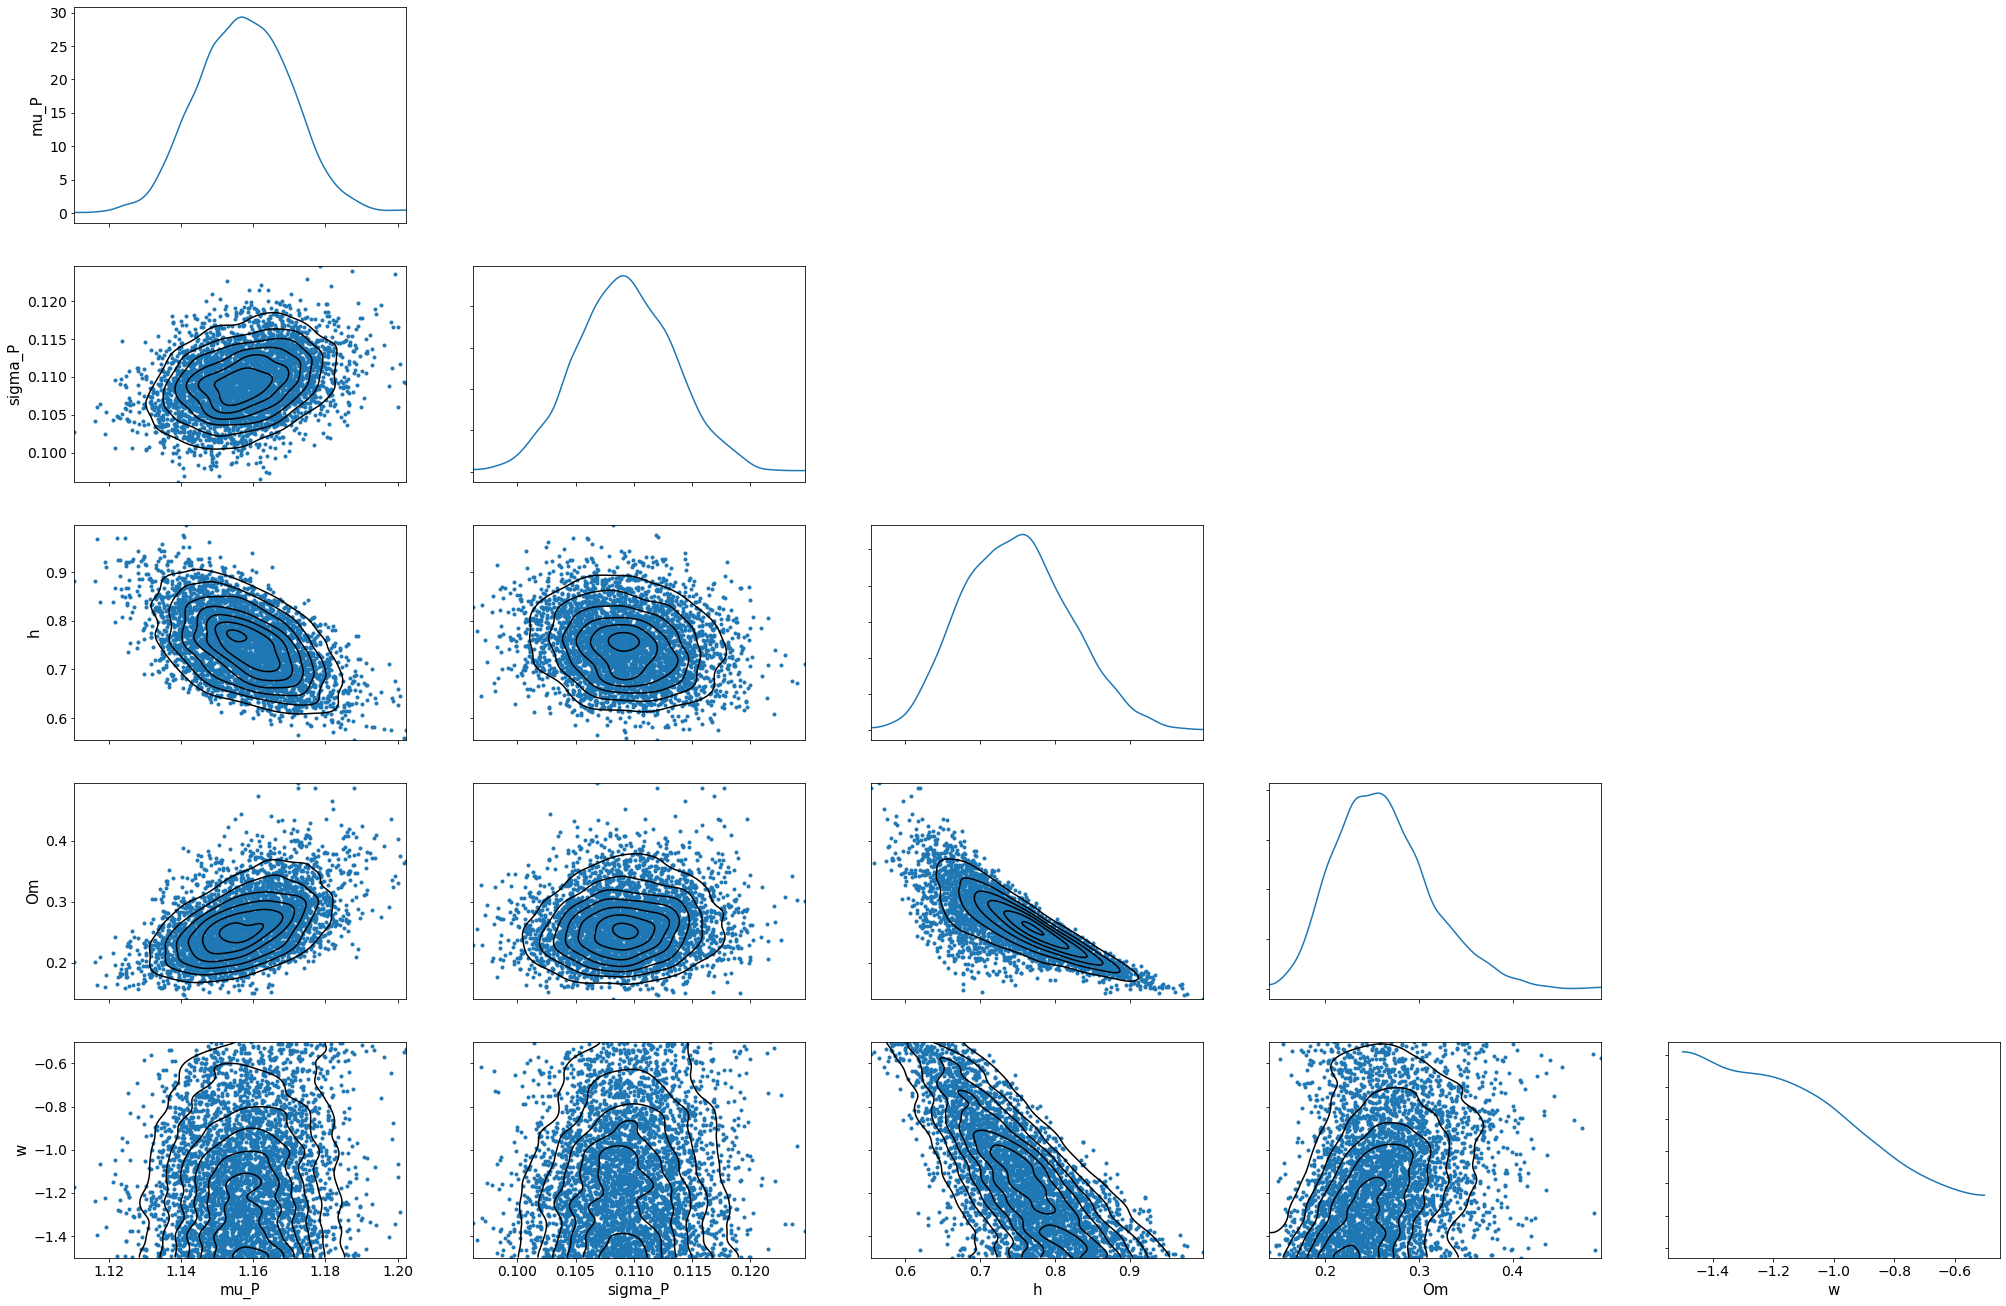

In [23]:
axes = az.plot_pair(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes.ravel()[0].figure

In [24]:
with model:
    display(az.summary(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_P,1.158,0.013,1.134,1.181,0.000,0.000,1945.0,2147.0,1.0
sigma_P,0.109,0.004,0.101,0.117,0.000,0.000,2682.0,2496.0,1.0
h,0.749,0.070,0.626,0.884,0.002,0.002,1029.0,1536.0,1.0
Om,0.262,0.052,0.173,0.363,0.001,0.001,1388.0,1561.0,1.0
w,-1.109,0.261,-1.500,-0.639,0.006,0.004,1699.0,1530.0,1.0
